### Version
Version 2:  
Add the calculated population as active/microbusiness_density * 100 - as indicated in the competition info

In [2]:
# import data science relevent libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext lab_black

In [3]:
df = pd.read_csv("../data/raw/train.csv")

In [4]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


### We get quarterly microdensities

In [6]:
df["first_day_of_month"].unique()

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01'], dtype=object)

In [7]:
# count missing values per column
print(f"mising values per column:\n{df.isnull().sum()}\n")
print(f"Count of values per column:\n{df.count()}")

mising values per column:
row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

Count of values per column:
row_id                   122265
cfips                    122265
county                   122265
state                    122265
first_day_of_month       122265
microbusiness_density    122265
active                   122265
dtype: int64


### Unique counties

In [8]:
df["county"].unique().shape

(1871,)

## Size distribution of counties
mostly to understand if we want to use all of them or just the highest populated

In [9]:
c_pop = pd.read_csv(
    "../data/raw/population_counties.csv",
    encoding="latin-1",
    usecols=[
        "REGION",
        "DIVISION",
        "STATE",
        "COUNTY",
        "STNAME",
        "CTYNAME",
        "POPESTIMATE2020",
        "POPESTIMATE2021",
    ],
)
c_pop.columns

Index(['REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'POPESTIMATE2020', 'POPESTIMATE2021'],
      dtype='object')

### Transform to cfips

In [10]:
c_pop["cfips"] = c_pop["STATE"] * 1000 + c_pop["COUNTY"]

In [11]:
c_pop.drop(columns=["STATE", "COUNTY", "DIVISION", "REGION"], inplace=True)
c_pop.head()

,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,cfips
0,Alabama,Alabama,5024803,5039877,1000
1,Alabama,Autauga County,58877,59095,1001
2,Alabama,Baldwin County,233140,239294,1003
3,Alabama,Barbour County,25180,24964,1005
4,Alabama,Bibb County,22223,22477,1007


In [12]:
# merge train data with population data
df = df.merge(c_pop, how="left", left_on="cfips", right_on="cfips")

In [13]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095


In [14]:
# add year column based on first_day_of_month
df["year"] = df["first_day_of_month"].str[:4].astype(int)

### Add calculated pop


In [15]:
df["population"] = np.where(
    df["microbusiness_density"] != 0,
    df["active"] / df["microbusiness_density"] * 100,
    df["POPESTIMATE2021"],
).astype(int)

In [16]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,41526
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,41526
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,41527
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527


### Plot county population distribution 2020

In [17]:
# build a df called df_2020 with only values for 2020
df_2020 = df[df["year"] == 2020].copy()
# only 1 row per county with the latest for each column
df_2020 = (
    df_2020.groupby(["cfips", "county", "state", "STNAME", "CTYNAME"])
    .last()
    .reset_index()
)
df_2020.head()

,cfips,county,state,STNAME,CTYNAME,row_id,first_day_of_month,microbusiness_density,active,POPESTIMATE2020,POPESTIMATE2021,year,population
0,1001,Autauga County,Alabama,Alabama,Autauga County,1001_2020-12-01,2020-12-01,3.002558,1256,58877,59095,2020,41830
1,1003,Baldwin County,Alabama,Alabama,Baldwin County,1003_2020-12-01,2020-12-01,8.224466,13359,233140,239294,2020,162429
2,1005,Barbour County,Alabama,Alabama,Barbour County,1005_2020-12-01,2020-12-01,1.032144,210,25180,24964,2020,20345
3,1007,Bibb County,Alabama,Alabama,Bibb County,1007_2020-12-01,2020-12-01,1.309604,234,22223,22477,2020,17867
4,1009,Blount County,Alabama,Alabama,Blount County,1009_2020-12-01,2020-12-01,1.613962,713,59081,59041,2020,44176


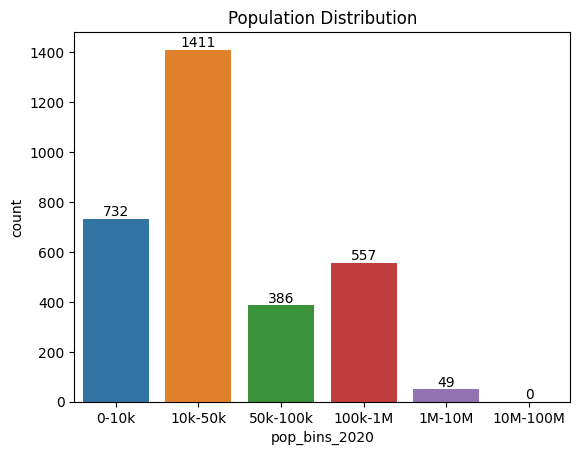

In [18]:
# create bins for POPESTIMATE2020
df_2020["pop_bins_2020"] = pd.cut(
    df_2020["POPESTIMATE2020"],
    bins=[0, 10000, 50000, 100000, 1000000, 10000000, 100000000],
    labels=["0-10k", "10k-50k", "50k-100k", "100k-1M", "1M-10M", "10M-100M"],
)

# plot the distribution of the bins
sns.countplot(x="pop_bins_2020", data=df_2020)
plt.title("Population Distribution")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.show()

### Population reflection
We have many counties that have smaller populations, however these counties might have noisy data. lets explore this

## Explore noise based on population

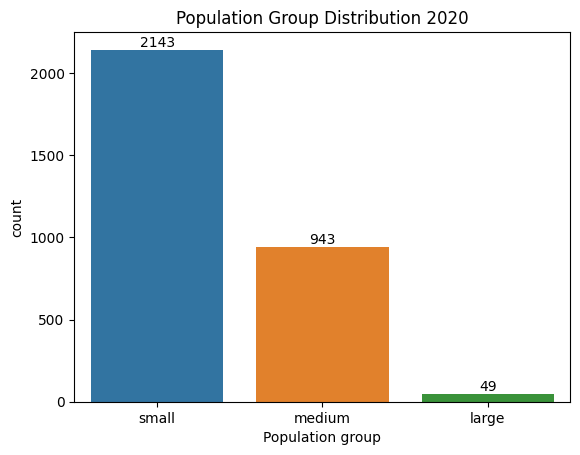

In [19]:
# divide the data into 3 groups based on the population bins, smaller than 50k small, between 50k and 1M medium, and larger than 1M large
df_2020["pop_group_2020"] = pd.cut(
    df_2020["POPESTIMATE2020"],
    bins=[0, 50000, 1000000, 100000000],
    labels=["small", "medium", "large"],
)
# plot the distribution of the groups
sns.countplot(x="pop_group_2020", data=df_2020)
plt.title("Population Group Distribution 2020")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.xlabel("Population group")
plt.show()

In [20]:
df_2020_small = df_2020[df_2020["pop_group_2020"] == "small"]
df_2020_meadium = df_2020[df_2020["pop_group_2020"] == "medium"]
df_2020_large = df_2020[df_2020["pop_group_2020"] == "large"]

<AxesSubplot: xlabel='microbusiness_density', ylabel='Density'>

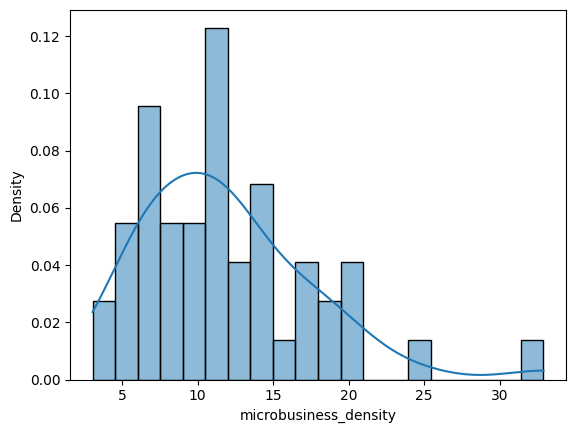

In [21]:
# plot microbusiness density for large counties
sns.histplot(
    x="microbusiness_density",
    data=df_2020_large,
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)

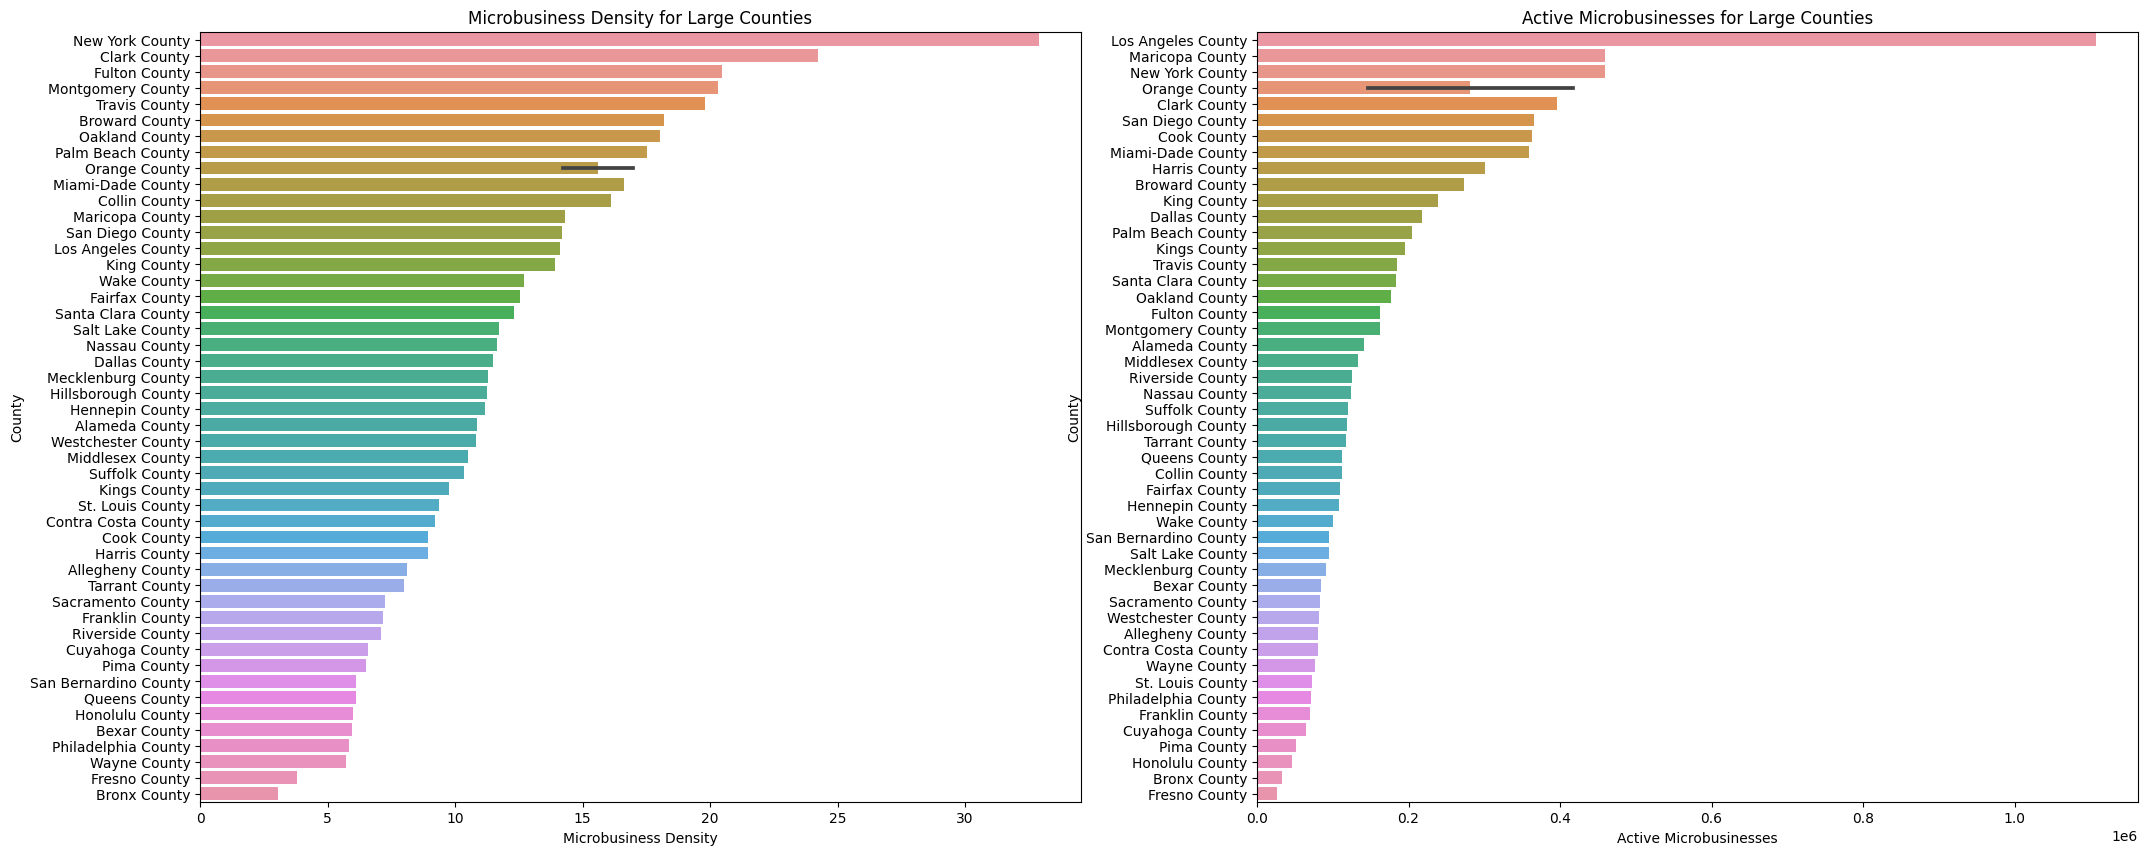

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
sns.barplot(
    x="microbusiness_density",
    y="CTYNAME",
    data=df_2020_large.sort_values("microbusiness_density", ascending=False),
    ax=ax[0],
)
ax[0].set_title("Microbusiness Density for Large Counties")
ax[0].set_xlabel("Microbusiness Density")
ax[0].set_ylabel("County")
sns.barplot(
    x="active",
    y="CTYNAME",
    data=df_2020_large.sort_values("active", ascending=False),
    ax=ax[1],
)
ax[1].set_title("Active Microbusinesses for Large Counties")
ax[1].set_xlabel("Active Microbusinesses")
ax[1].set_ylabel("County")
plt.show()

### In order to compare the three we can compare the distribution of microbussiness density of the 3

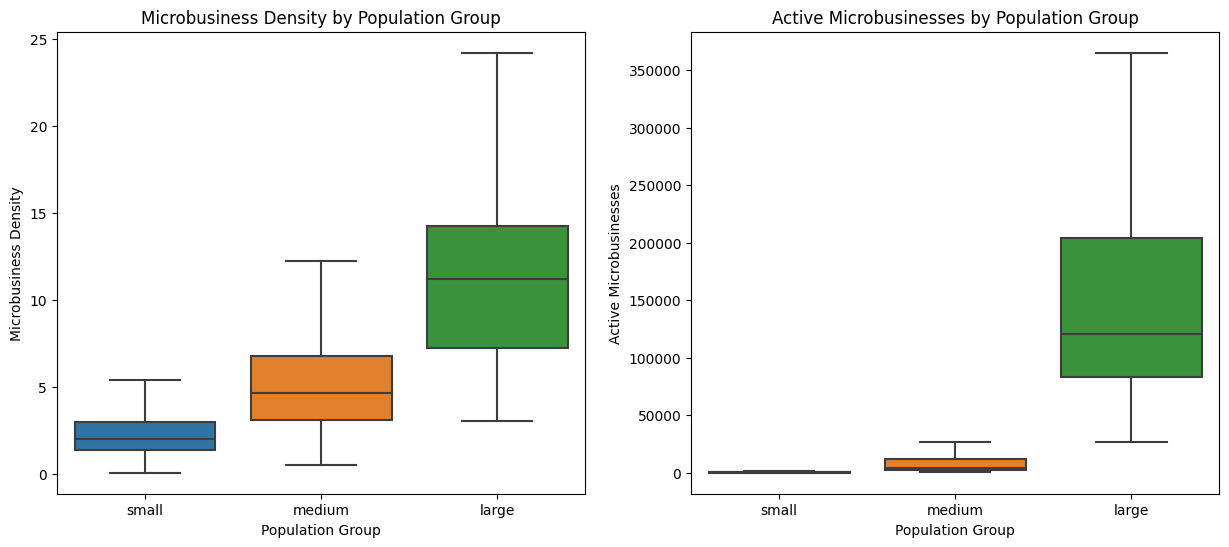

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(
    x="pop_group_2020",
    y="microbusiness_density",
    data=df_2020,
    showfliers=False,
    ax=ax[0],
)
ax[0].set_title("Microbusiness Density by Population Group")
ax[0].set_xlabel("Population Group")
ax[0].set_ylabel("Microbusiness Density")
sns.boxplot(x="pop_group_2020", y="active", data=df_2020, showfliers=False, ax=ax[1])
ax[1].set_title("Active Microbusinesses by Population Group")
ax[1].set_xlabel("Population Group")
ax[1].set_ylabel("Active Microbusinesses")

plt.show()

### Reflection 
While the boxplot of density shows higher variation in the large counties. The amount of active microbusiness is rather small in the smaller ones,  
which could still cause noise if we model it. Specially  
because it might be hard to map the effect of features on these small counties , is the data quality even good?

## Lets see general info about microbusiness density and active microbusinesses
Lets create some features that represent the year and quarter of the information

In [24]:
# create a quarter column that devides the year in 4 quarters, 1, 2, 3, 4

df["quarter"] = df["first_day_of_month"].str[5:7].astype(int)
df["quarter"] = df["quarter"].apply(
    lambda x: 1 if x <= 3 else 2 if x <= 6 else 3 if x <= 9 else 4
)
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,41526,3
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,41526,3
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,41527,4
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4


In [25]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,41526,3
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,41526,3
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,41527,4
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4


In [26]:
# descriptive statistics of the latest quarter
df_latest = df[(df["quarter"] == 4) & (df["year"] == 2022)].copy()
df_latest[["microbusiness_density", "active"]].describe()

,microbusiness_density,active
count,3135.000000,3.135000e+03
mean,4.006963,6.797221e+03
std,6.160199,3.453032e+04
min,0.000000,0.000000e+00
25%,1.704740,1.495000e+02
50%,2.687274,5.130000e+02
75%,4.663819,2.209500e+03
max,227.756650,1.153292e+06


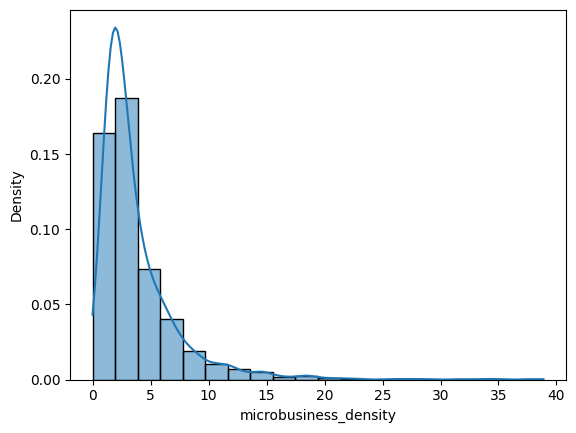

In [27]:
# plot the distribution of microbusiness density
sns.histplot(
    x="microbusiness_density",
    data=df_latest[df_latest["microbusiness_density"] < 40],
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.show()

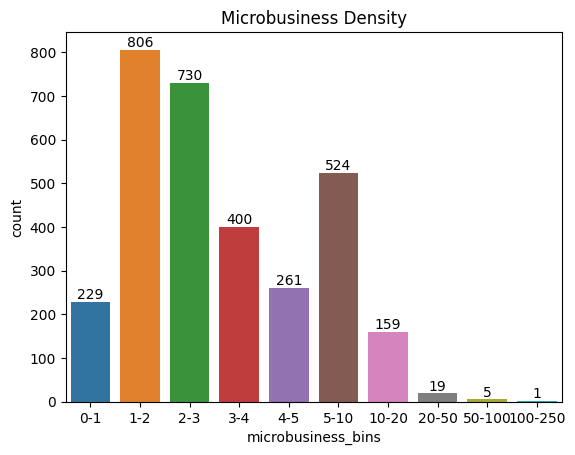

In [28]:
density_bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 250]
df_latest["microbusiness_bins"] = pd.cut(
    df_latest["microbusiness_density"],
    density_bins,
    labels=[
        f"{density_bins[i]}-{density_bins[i+1]}" for i in range(len(density_bins) - 1)
    ],
)
fig, ax = plt.subplots(1, 1)
sns.countplot(x="microbusiness_bins", data=df_latest, ax=ax)
plt.title("Microbusiness Density")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.show()

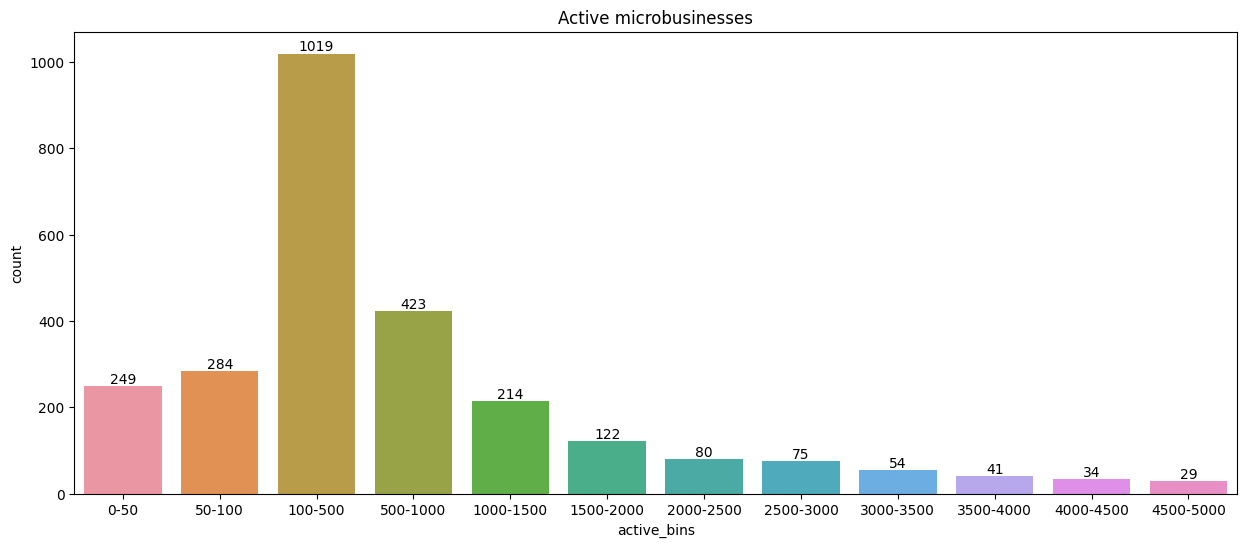

In [29]:
# create bins for the active column and plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
active_bins = [0, 50, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
df_latest["active_bins"] = pd.cut(
    df_latest["active"],
    active_bins,
    labels=[
        f"{active_bins[i]}-{active_bins[i+1]}" for i in range(len(active_bins) - 1)
    ],
)

sns.countplot(x="active_bins", data=df_latest, ax=ax)
plt.title("Active microbusinesses")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.show()

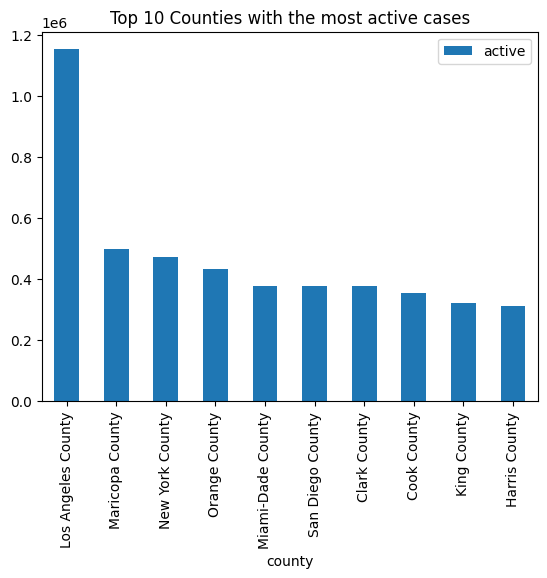

In [30]:
# visualize the top counties with the most active cases
df_latest.sort_values("active", ascending=False).head(10)[["county", "active"]].plot(
    kind="bar", x="county", y="active"
)
plt.title("Top 10 Counties with the most active cases")
plt.show()

In [31]:
df["pop_group_2020"] = pd.cut(
    df["POPESTIMATE2020"],
    bins=[0, 50000, 1000000, 100000000],
    labels=["small", "medium", "large"],
)

In [32]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter,pop_group_2020
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,41526,3,medium
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,41526,3,medium
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,41527,4,medium
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium


## Population 2022
Using the calculated pop

In [35]:
# build a df called df_2020 with only values for 2020
df_2022 = df[df["year"] == 2022].copy()
# only 1 row per county with the latest for each column
df_2022 = (
    df_2022.groupby(["cfips", "county", "state", "STNAME", "CTYNAME"])
    .last()
    .reset_index()
)
df_2022.head()

,cfips,county,state,STNAME,CTYNAME,row_id,first_day_of_month,microbusiness_density,active,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter,pop_group_2020
0,1001,Autauga County,Alabama,Alabama,Autauga County,1001_2022-10-01,2022-10-01,3.463856,1472,58877,59095,2022,42495,4,medium
1,1003,Baldwin County,Alabama,Alabama,Baldwin County,1003_2022-10-01,2022-10-01,8.359798,14320,233140,239294,2022,171295,4,medium
2,1005,Barbour County,Alabama,Alabama,Barbour County,1005_2022-10-01,2022-10-01,1.232074,244,25180,24964,2022,19803,4,small
3,1007,Bibb County,Alabama,Alabama,Bibb County,1007_2022-10-01,2022-10-01,1.287240,229,22223,22477,2022,17790,4,small
4,1009,Blount County,Alabama,Alabama,Blount County,1009_2022-10-01,2022-10-01,1.831783,813,59081,59041,2022,44382,4,medium


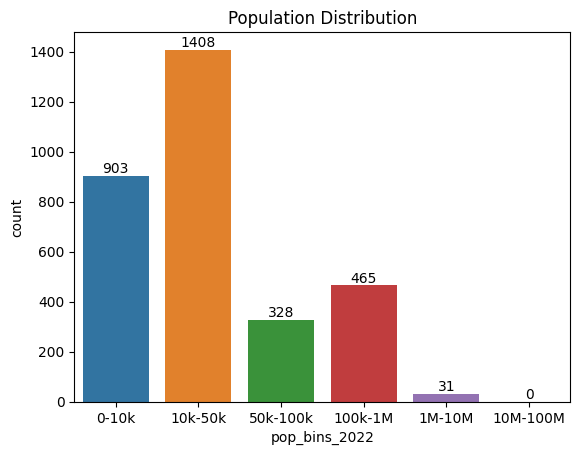

In [36]:
# create bins for POPESTIMATE2020
df_2022["pop_bins_2022"] = pd.cut(
    df_2022["population"],
    bins=[0, 10000, 50000, 100000, 1000000, 10000000, 100000000],
    labels=["0-10k", "10k-50k", "50k-100k", "100k-1M", "1M-10M", "10M-100M"],
)

# plot the distribution of the bins
sns.countplot(x="pop_bins_2022", data=df_2022)
plt.title("Population Distribution")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.show()

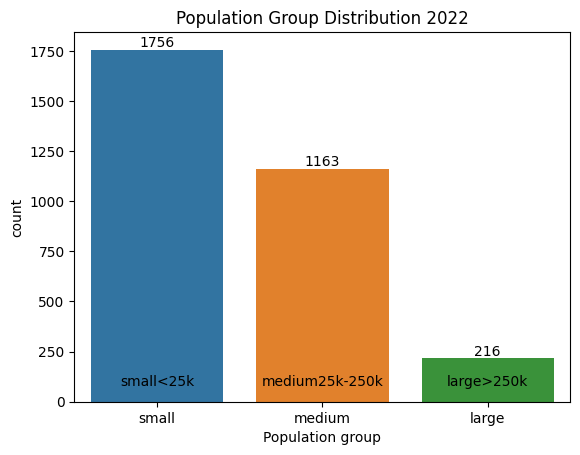

In [41]:
# divide the data into 3 groups based on the population bins, smaller than 25k small, between 25k and 250k medium, and larger than 250M large
df_2022["pop_group_2022"] = pd.cut(
    df_2022["population"],
    bins=[0, 25000, 250000, 100000000],
    labels=["small", "medium", "large"],
)
# plot the distribution of the groups
sns.countplot(x="pop_group_2022", data=df_2022)
plt.title("Population Group Distribution 2022")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.xlabel("Population group")
# make visual what the groups are
plt.text(0, 100, "small<25k", ha="center", va="center")
plt.text(1, 100, "medium25k-250k", ha="center", va="center")
plt.text(2, 100, "large>250k", ha="center", va="center")

plt.show()

In [42]:
pop_sizes = ["small", "medium", "large"]
for i in range(len(pop_sizes)):
    print(
        f"{pop_sizes[i]}: {df_2022[df_2022['pop_group_2022'] == pop_sizes[i]].shape[0]}"
    )

small: 1756
medium: 1163
large: 216


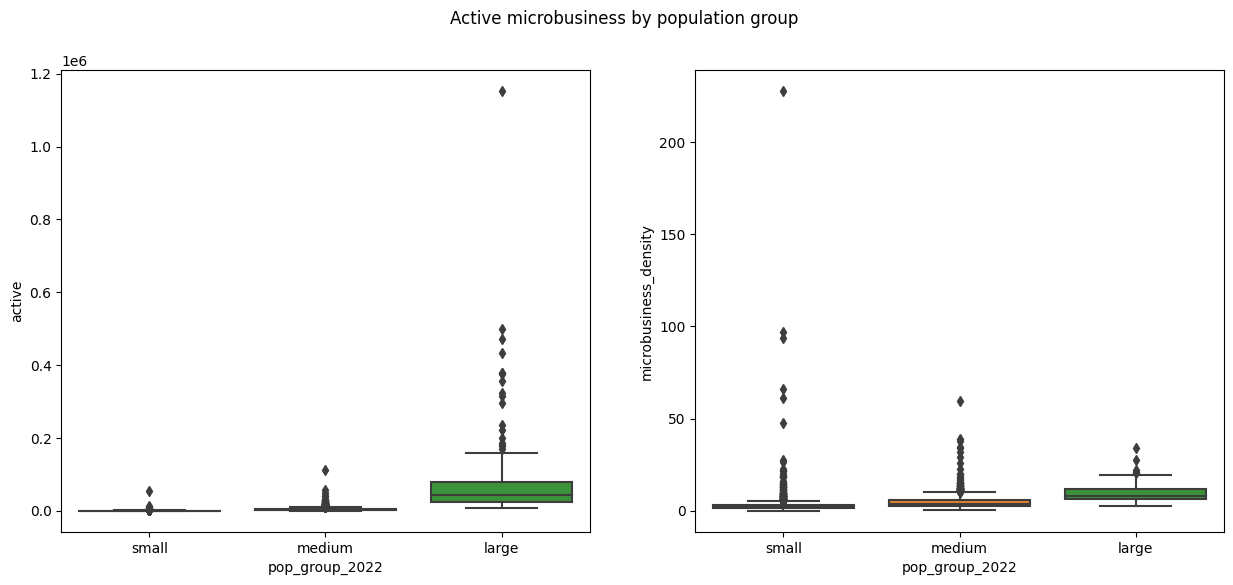

In [62]:
# plot the distribution of the active cases and the microbusiness side by side by population group
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x="pop_group_2022", y="active", data=df_2022, ax=ax[0])
sns.boxplot(x="pop_group_2022", y="microbusiness_density", data=df_2022, ax=ax[1])
plt.suptitle("Active microbusiness by population group")
plt.show()

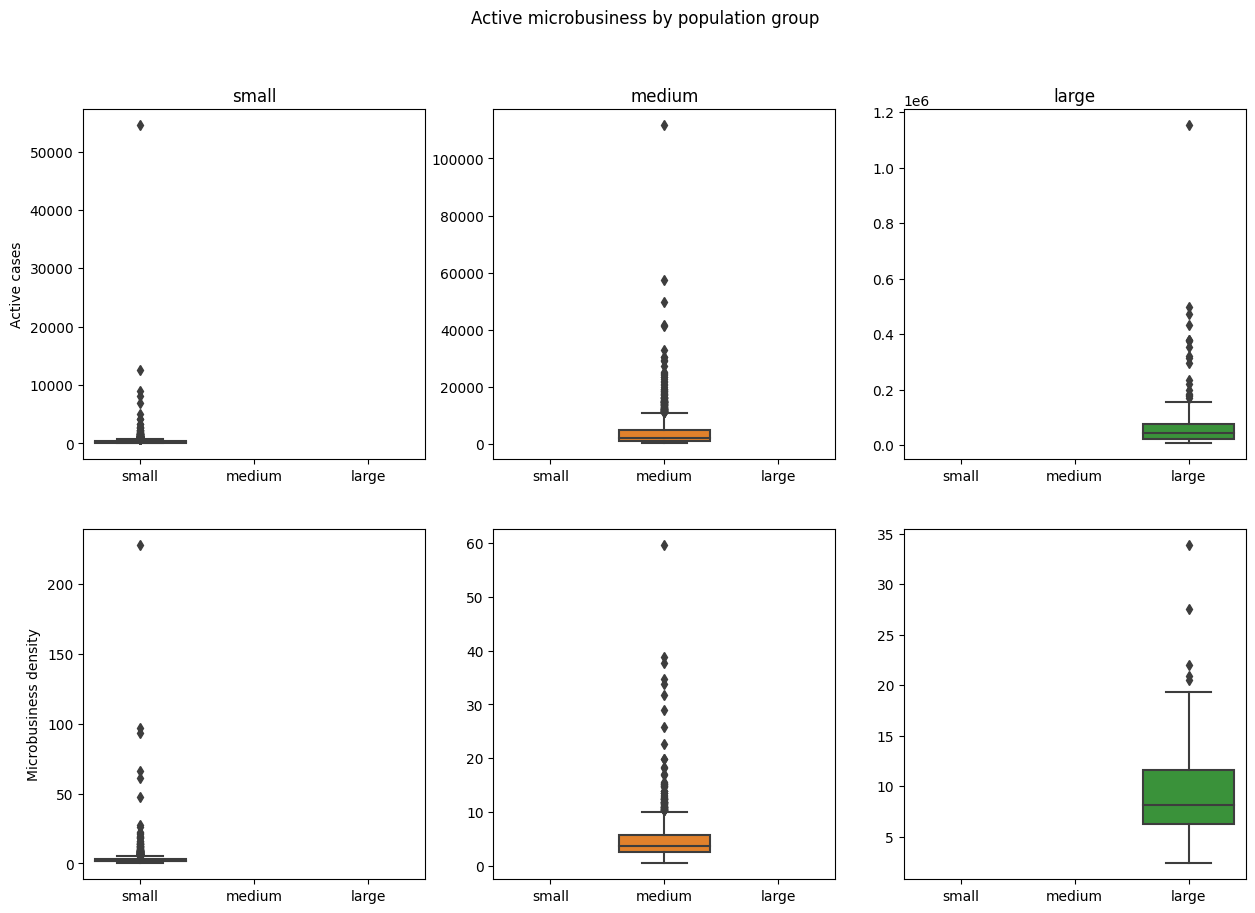

In [68]:
# 3 graphs, one for each population group
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(pop_sizes)):
    sns.boxplot(
        x="pop_group_2022",
        y="active",
        data=df_2022[df_2022["pop_group_2022"] == pop_sizes[i]],
        ax=ax[0, i],
    )
    sns.boxplot(
        x="pop_group_2022",
        y="microbusiness_density",
        data=df_2022[df_2022["pop_group_2022"] == pop_sizes[i]],
        ax=ax[1, i],
    )
    ax[0, i].set_xlabel("")
    ax[1, i].set_xlabel("")
    # show y label only for the first graph
    if i == 0:
        ax[0, i].set_ylabel("Active cases")
        ax[1, i].set_ylabel("Microbusiness density")
    else:
        ax[0, i].set_ylabel("")
        ax[1, i].set_ylabel("")
    ax[0, i].set_title(f"{pop_sizes[i]}")


plt.suptitle("Active microbusiness by population group")
plt.show()

In [73]:
# descriptive statistics for the active cases and the microbusiness density by population group
df_2022.groupby("pop_group_2022").agg(
    {"active": "describe", "microbusiness_density": "describe"}
)

active                                                 \
                 count          mean            std     min       25%   
pop_group_2022                                                          
small           1756.0    339.516515    1417.148164     0.0     81.75   
medium          1163.0   4084.823732    6144.585857   116.0    980.00   
large            216.0  73900.212963  110706.258512  6875.0  23035.00   

                                            microbusiness_density            \
                    50%      75%        max                 count      mean   
pop_group_2022                                                                
small             174.0    355.0    54509.0                1756.0  2.930048   
medium           2024.0   4968.5   111680.0                1163.0  4.639620   
large           42636.0  78246.5  1153292.0                 216.0  9.355500   

                                                                               
                     std       min       25%       50%        75%         max  
pop_group_2022                                                                 
small           7.058623  0.000000  1.349888  1.969987   2.927911  227.756650  
medium          3.962073  0.426690  2.483148  3.626101   5.611935   59.590317  
large           4.608184  2.340689  6.207581  8.169079  11.557999   33.852085

## Reflection:
- We can see that the small groupsize can have much larger extremes when it comes to density. The std deviation is the largest.
- The active on the other hand tends to follow a bit the population size, so for larger pops we have larger active microbusiness count
- When we look at mean/median we see that it also follows the pop size for densities. larger cities tend to have a higher microb_density in average

## Deeper exploration, of deviations:

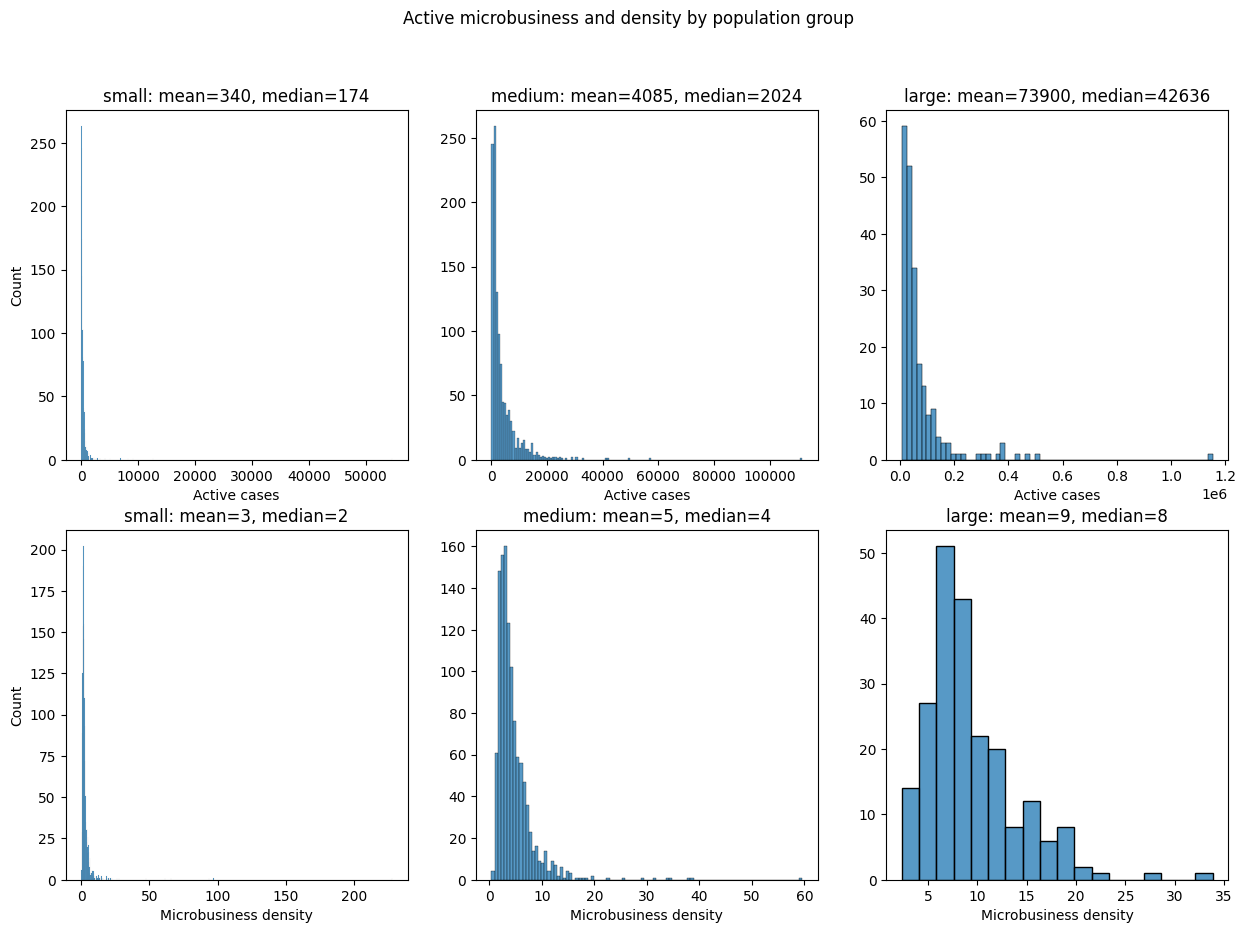

In [77]:
# for each group do a histogram of the active cases and the microbusiness density
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(pop_sizes)):
    sns.histplot(
        data=df_2022[df_2022["pop_group_2022"] == pop_sizes[i]],
        x="active",
        ax=ax[0, i],
    )
    sns.histplot(
        data=df_2022[df_2022["pop_group_2022"] == pop_sizes[i]],
        x="microbusiness_density",
        ax=ax[1, i],
    )
    ax[0, i].set_xlabel("Active cases")
    ax[1, i].set_xlabel("Microbusiness density")
    # show y label only for the first graph
    if i == 0:
        ax[0, i].set_ylabel("Count")
        ax[1, i].set_ylabel("Count")
    else:
        ax[0, i].set_ylabel("")
        ax[1, i].set_ylabel("")
    # show the population group in the title and the mean and median in the subtitle
    ax[0, i].set_title(
        f"{pop_sizes[i]}: mean={df_2022[df_2022['pop_group_2022'] == pop_sizes[i]]['active'].mean():.0f}, median={df_2022[df_2022['pop_group_2022'] == pop_sizes[i]]['active'].median():.0f}"
    )
    ax[1, i].set_title(
        f"{pop_sizes[i]}: mean={df_2022[df_2022['pop_group_2022'] == pop_sizes[i]]['microbusiness_density'].mean():.0f}, median={df_2022[df_2022['pop_group_2022'] == pop_sizes[i]]['microbusiness_density'].median():.0f}"
    )
    plt.suptitle("Active microbusiness and density by population group")

### Lets explore extreme values
1. 3 Standard dev
2. IQR RULE: more than 1.5 times the IQR away from the 25th or 75th percentile.

In [83]:
# For each population group lets see how many extremes we have. We define an extreme as a value that is more than 3 standard deviations away from the mean.
print("We have the following number of extreme values:")
for i in range(len(pop_sizes)):
    print(
        f"{pop_sizes[i]}: active={df_2022[(df_2022['pop_group_2022'] == pop_sizes[i]) & (df_2022['active'] > df_2022['active'].mean() + 3 * df_2022['active'].std())].shape[0]}, microbusiness_density={df_2022[(df_2022['pop_group_2022'] == pop_sizes[i]) & (df_2022['microbusiness_density'] > df_2022['microbusiness_density'].mean() + 3 * df_2022['microbusiness_density'].std())].shape[0]}"
    )
# The mean and std for each pop group are:
df_2022.groupby("pop_group_2022").agg(
    {"active": ["mean", "std"], "microbusiness_density": ["mean", "std"]}
)

We have the following number of extreme values:
small: active=0, microbusiness_density=9
medium: active=1, microbusiness_density=9
large: active=35, microbusiness_density=2


active                microbusiness_density          
                        mean            std                  mean       std
pop_group_2022                                                             
small             339.516515    1417.148164              2.930048  7.058623
medium           4084.823732    6144.585857              4.639620  3.962073
large           73900.212963  110706.258512              9.355500  4.608184

In [88]:
# Lets see how many extreme values we have for the active cases and the microbusiness density by population group.
# The extreme values are defined by the IQR rule. We consider an extreme value if it is more than 1.5 times the IQR away from the 25th or 75th percentile.
print("We have the following number of extreme values:")
for i in range(len(pop_sizes)):
    print(
        f"""{pop_sizes[i]}:
        active={df_2022[(df_2022['pop_group_2022'] == pop_sizes[i])
        & ((df_2022['active'] > df_2022['active'].quantile(0.75) + 1.5 * (df_2022['active'].quantile(0.75) - df_2022['active'].quantile(0.25)))
        | (df_2022['active'] < df_2022['active'].quantile(0.25) - 1.5 * (df_2022['active'].quantile(0.75) - df_2022['active'].quantile(0.25))))].shape[0]},
        microbusiness_density={df_2022[(df_2022['pop_group_2022'] == pop_sizes[i])
        & ((df_2022['microbusiness_density'] > df_2022['microbusiness_density'].quantile(0.75) + 1.5 * (df_2022['microbusiness_density'].quantile(0.75) - df_2022['microbusiness_density'].quantile(0.25)))
        | (df_2022['microbusiness_density'] < df_2022['microbusiness_density'].quantile(0.25) - 1.5 * (df_2022['microbusiness_density'].quantile(0.75) - df_2022['microbusiness_density'].quantile(0.25))))].shape[0]}
        """
    )

We have the following number of extreme values:
small:
        active=5,
        microbusiness_density=46
        
medium:
        active=273,
        microbusiness_density=86
        
large:
        active=216,
        microbusiness_density=89
        


In [93]:
# Bring the pop group 2022 to the original df
df["pop_group_2022"] = pd.cut(
    df["population"],
    bins=[0, 25000, 250000, 100000000],
    labels=["small", "medium", "large"],
)

In [94]:
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter,pop_group_2020,pop_group_2022
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,Wyoming,Weston County,6809,6745,2022,5600,2,small,small
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,Wyoming,Weston County,6809,6745,2022,5600,3,small,small
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,Wyoming,Weston County,6809,6745,2022,5600,3,small,small
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,Wyoming,Weston County,6809,6745,2022,5600,3,small,small


## Persist

In [95]:
df.to_csv("../data/processed/county_data.csv", index=False)